In [1]:
import uproot as ur
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
# Package used to make nice plots
import mplhep as hep
hep.style.use(hep.style.CMS)

### Opening the ZDC neutron data file
#### The data file has an "events" tree, which has multiple branches containing different information. In our case, a single event is when we fire a neutron into the ZDC. The two branches we'll be looking at are MCParticles and ZDCHcalHitsReco.<br /> The MCParticles branch contains the "truth level" information about our simulation. For instance, if we fire a neutron at the ZDC with energy 5 GeV and $\theta = 2^{\circ}$, this branch will contain these numbers.<br /> The ZDCHcalHitsReco contains the data from the ZDC. The ZDC has multiple cells, each readout by SiPMs (think of the hexagonal scintillators from the lab!), and the cell information is contained in this branch. This includes the energy each cell receives in a given event and the positions of the cells.
#### We separate these branches into different arrays in the below cell

In [2]:
# Opening a data file. You can choose any data file from the below data_directory.
data_directory = "/media/miguel/Elements/zdc_data/zdc_neutron_log10discrete_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/"
file_name = "reco_neutron_discrete_10GeV-300GeV_theta_0.0deg-0.3deg_1325547_0.edm4hep.root"
with ur.open(f"{data_directory + file_name}:events") as events:
    # Obtaining arrays for MCparticles branch
    zdc_MC = events.arrays(["MCParticles.generatorStatus", "MCParticles.PDG",'MCParticles.mass',
                            'MCParticles.momentum.x', 'MCParticles.momentum.y', 'MCParticles.momentum.z'])
    # Obtaining arrays for ZDCHcalHitsReco branch
    zdc_reco = events.arrays(["ZDCHcalHitsReco.energy", "ZDCHcalHitsReco.time",
                             "ZDCHcalHitsReco.position.x", "ZDCHcalHitsReco.position.y", "ZDCHcalHitsReco.position.z"])
    print("Number of events:", events.num_entries)

Number of events: 10000


### Plotting some truth level information from the MCParticles branch
#### All the arrays in this dataset are nested arrays -- there is one big array containing multiple other arrays. Each of these nested arrays stores the data for an individual event. If we don't care about keeping the events in separate arrays, we can flatten them to put the data from the nested arrays into one big array.<br /> There is information for multiple particles in the simulation. To get info about about the neutron we fire, we need to use the below mask on generatorStatus. You don't need to understand what that means for now but that's how the information is obtained.
#### A couple of things to note about the plots you'll obtain in this cell: <br /> - There are multiple values for our neutron energy. The neutron energy for each event was chosen randomly from a set of values. In an actual experiment, we can't control the neutron energy so we've chosen some possible values for the energy the neutron can have.<br /> - The $\theta$ values are very small -- on the scale of milliradians. Remember, this is a Zero Degree Calorimeter and it detects particles that were scattered at very small angles.

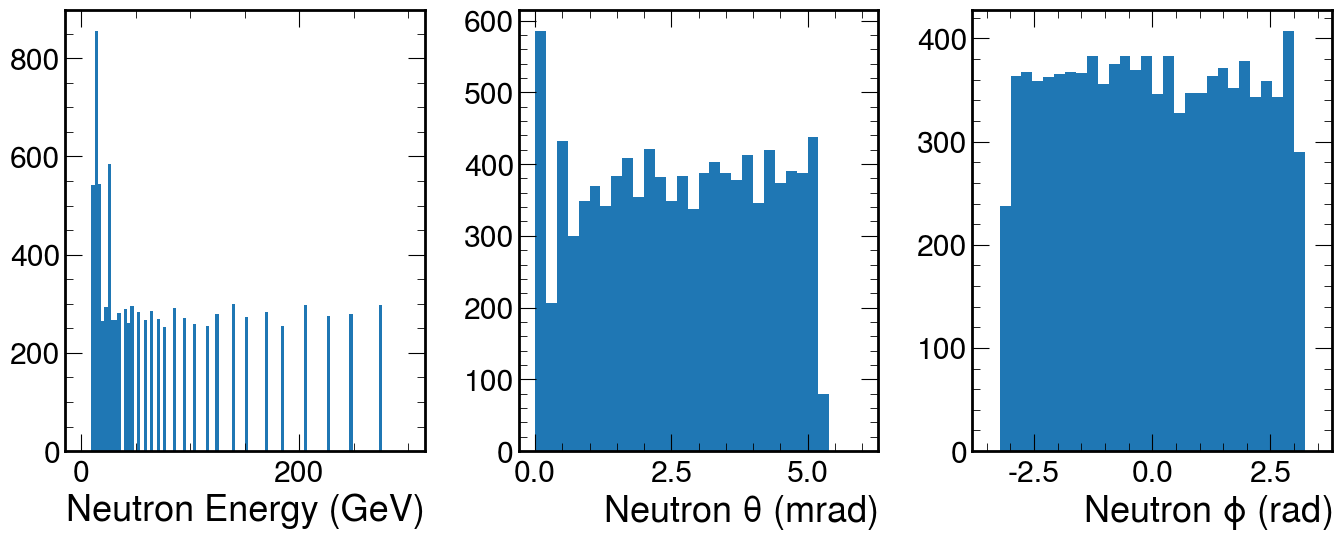

In [3]:
# Mask to get incident neutron information
neutron_mask = (zdc_MC["MCParticles.generatorStatus"]==1)

# Getting the momentum in different directions and mass of the neutrons
neutron_px = zdc_MC["MCParticles.momentum.x"][neutron_mask]
neutron_py = zdc_MC["MCParticles.momentum.y"][neutron_mask]
neutron_pz = zdc_MC["MCParticles.momentum.z"][neutron_mask]
neutron_mass = zdc_MC["MCParticles.mass"][neutron_mask]

# Calculating the neutron's energy and the angles it was fired at
neutron_mom = np.sqrt(neutron_px**2 + neutron_py**2 + neutron_pz**2)
neutron_energy = np.sqrt(neutron_mom**2 + neutron_mass**2) # Units = GeV
neutron_theta = np.arccos(neutron_pz/neutron_mom) # Units = radians
neutron_phi = np.arctan2(neutron_py, neutron_px) # Units = radians

# Plotting the neutron energy & angles
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(14,6))

ax1.hist(ak.flatten(neutron_energy), bins = 100, range = [0, 300], histtype='stepfilled')
ax1.set_xlabel("Neutron Energy (GeV)")

# Convert to a numpy array to multiply by 1000 and go to milliradians
ax2.hist(np.asarray(ak.flatten(neutron_theta))*1000, bins = 30, range=[0, 6], histtype='stepfilled')
ax2.set_xlabel("Neutron $\\theta$ (mrad)")

ax3.hist(ak.flatten(neutron_phi), bins = 30, range=[-1.1*np.pi, 1.1*np.pi], histtype='stepfilled')
ax3.set_xlabel("Neutron $\phi$ (rad)")

plt.tight_layout()

### Plotting ZDC data
#### We will now plot some data from the ZDC cells. We'll focus on the cell energies and positions.

In [4]:
zdc_x_pos = zdc_reco["ZDCHcalHitsReco.position.x"]
zdc_y_pos = zdc_reco["ZDCHcalHitsReco.position.y"]
zdc_z_pos = zdc_reco["ZDCHcalHitsReco.position.z"]
zdc_energies = zdc_reco["ZDCHcalHitsReco.energy"] #use this for reconstruct

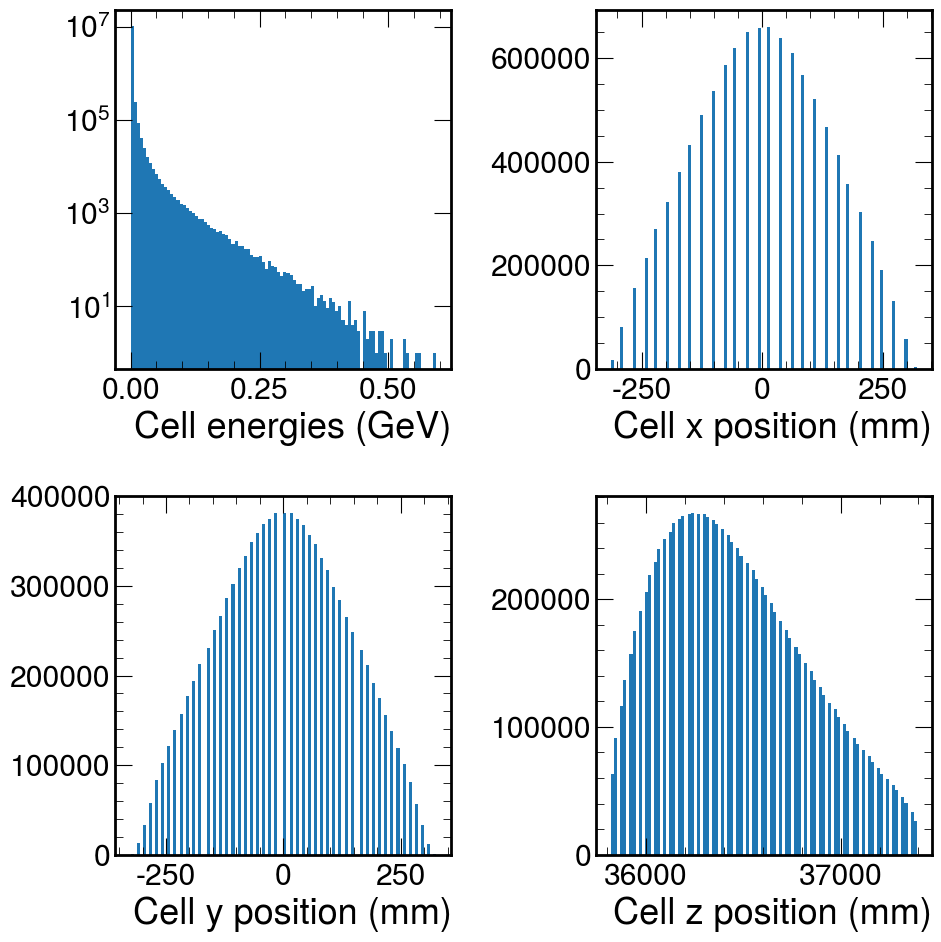

In [5]:
_, axs = plt.subplots(2, 2, figsize = (10,10))

axs[0][0].hist(ak.flatten(zdc_energies), bins=100)
axs[0][0].set_yscale('log')
axs[0][0].set_xlabel("Cell energies (GeV)")

axs[0][1].hist(ak.flatten(zdc_x_pos), bins = 100)
axs[0][1].set_xlabel("Cell x position (mm)")

axs[1][0].hist(ak.flatten(zdc_y_pos), bins = 100)
axs[1][0].set_xlabel("Cell y position (mm)")

axs[1][1].hist(ak.flatten(zdc_z_pos), bins = 100)
axs[1][1].set_xlabel("Cell z position (mm)")

plt.tight_layout()

### Reconstructing the event energy
#### Using the zdc_energies array, we can reconstruct the energy of the neutron that hit the ZDC for each event. To do this, do the following: <br /> 1. Add up the energies within each nested array (either by hand or using ak.sum)<br />2. Divide each of these by the sampling fraction. Remember, the ZDC only detects about 2% (sampling fraction = .02) of the incident neutron energy. So to estimate the incident neutron energy, we have to divide by this fraction.<br />3. Flatten the array and plot the histogram.<br /> Please store this array in the below variable, recontructed_event_energy.

[226, 31.8, 24.4, 170, 17.6, 25.5, 26.5, ..., 55, 101, 277, 151, 34.8, 72.4]


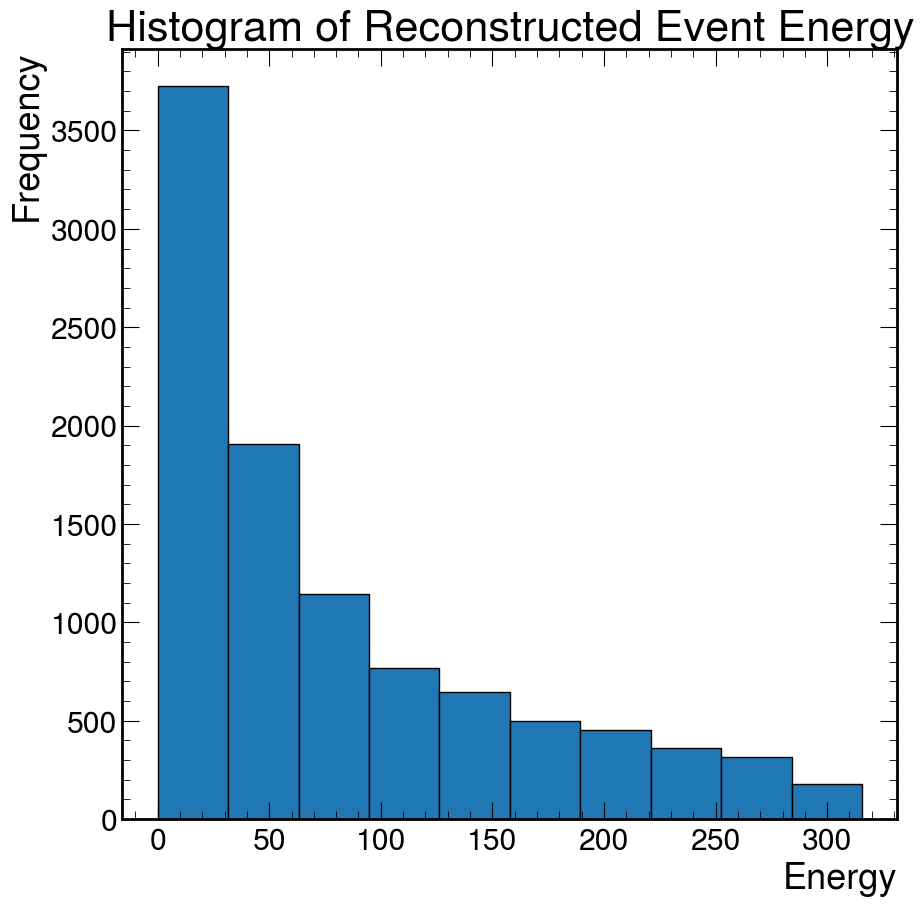

In [6]:
sum_axis1 = ak.sum(zdc_energies, axis=1)
sampling_fraction = 50.0*sum_axis1

reconstructed_event_energy = sampling_fraction

print (reconstructed_event_energy)
plt.hist(reconstructed_event_energy, bins=10, edgecolor='black')
plt.title("Histogram of Reconstructed Event Energy")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.show()

#### Now that we have the reconstructed neutron energy, we want to see how well our detector aligns with the true neutron energy. We can compare the two using the MCParticles arrays from before.

Text(0, 1, 'Reconstructed energy (GeV)')

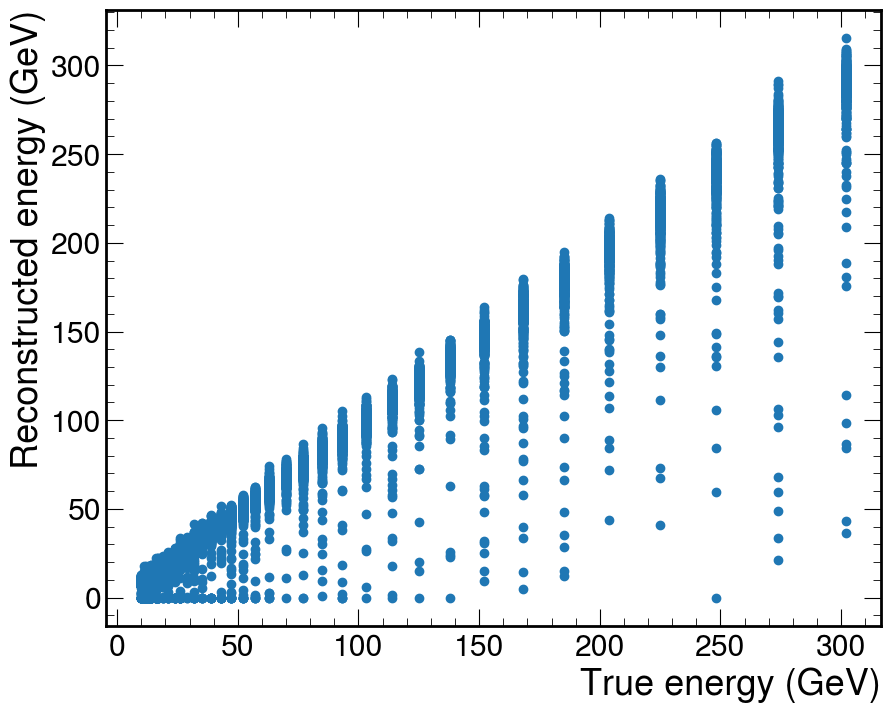

In [7]:
fig = plt.figure(figsize=(10,8))

plt.scatter(ak.flatten(neutron_energy), reconstructed_event_energy)
plt.xlabel("True energy (GeV)")
plt.ylabel("Reconstructed energy (GeV)")

### To-do:
#### With this you can now explore the concept of energy resolution. Please do the following:<br /> 1. From the true neutron energy array, pick a specific energy (any will do).<br />2. Create a mask that only selects events with that energy.<br />3. Apply the mask to the reconstructed_event_energy array. <br /> 4. Make a histogram of this reconstructed energy and fit it with a Gaussian function. <br />5. Calculate your energy resolution, which is $\sigma/\mu$ from your fit.
#### This is the basic analysis used for detector simulations and it provides insight into the detector performance.
#### 6. For the final step, calculate the energy resolutions for all the neutron energies and make a plot of energy resolution vs neutron energy.

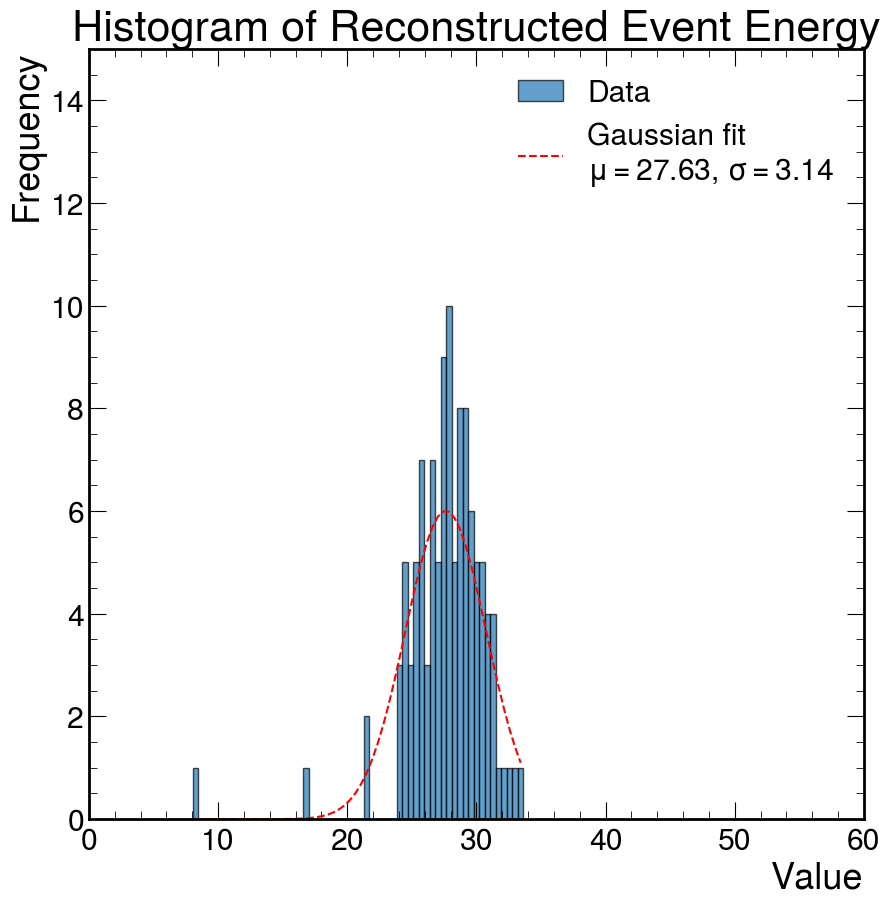

Energy Resolution (sigma/mu): 0.11
specific_energy: 29.02


In [8]:
from scipy.stats import norm
neutron_energy_flat = ak.flatten(neutron_energy)
specific_energy = neutron_energy_flat[5]
mask = (neutron_energy_flat == specific_energy)
masked_reconstructed_energy = reconstructed_event_energy[mask]
hist_data, bins, _ = plt.hist(masked_reconstructed_energy, bins=60, edgecolor='black', alpha=0.7, label='Data')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
(mu, sigma) = norm.fit(masked_reconstructed_energy)
best_fit_line = norm.pdf(bin_centers, mu, sigma) * sum(hist_data) * (bins[1] - bins[0])
plt.plot(bin_centers, best_fit_line, 'r--', label=f'Gaussian fit\n$\mu={mu:.2f}$, $\sigma={sigma:.2f}$')
plt.xlim(0,60)
plt.ylim(0,15)
plt.title('Histogram of Reconstructed Event Energy')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()
energy_resolution = sigma / mu
print(f'Energy Resolution (sigma/mu): {energy_resolution:.2f}')
print(f'specific_energy: {specific_energy:.2f}')

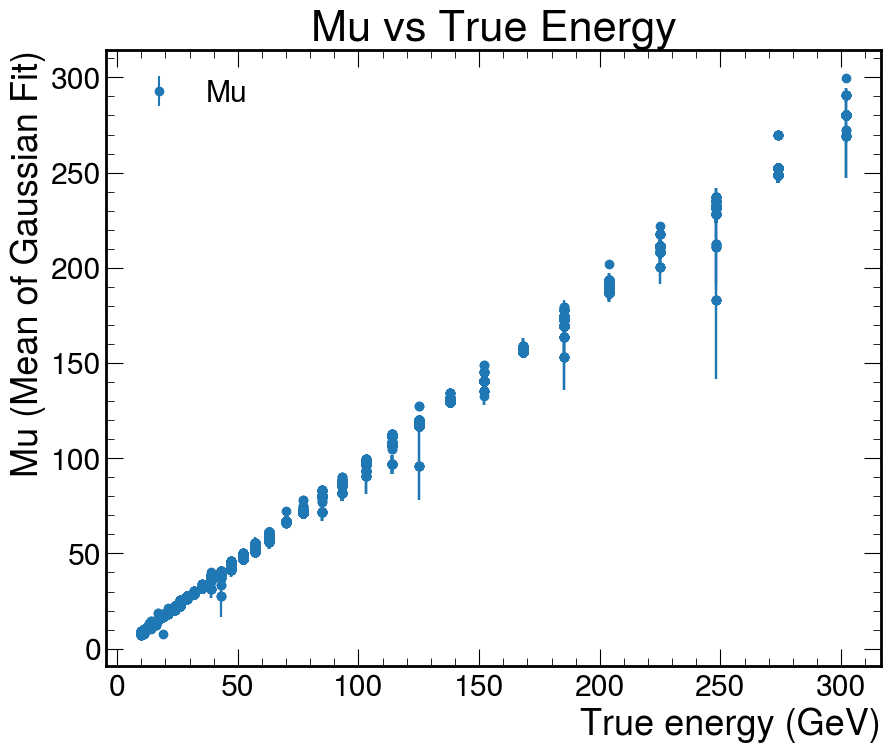

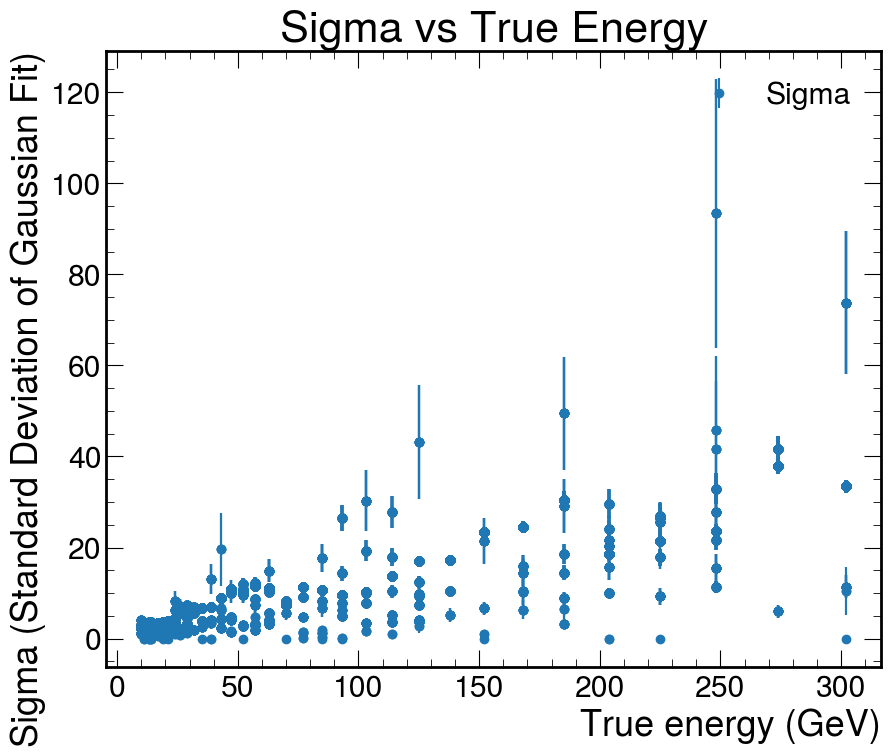

/usr/local/lib/python3.8/dist-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


ValueError: Image size of 1273x435492 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x800 with 1 Axes>

In [9]:
mu_values = []
sigma_values = []
mu_errors = []
sigma_errors = []

neutron_energy_flat = ak.flatten(neutron_energy)

# Loop over each unique neutron energy
for specific_energy in ak.to_numpy(neutron_energy_flat):
    mask = (neutron_energy_flat == specific_energy)
    masked_reconstructed_energy = reconstructed_event_energy[mask]

    if len(masked_reconstructed_energy) > 0:  # Only fit if there are elements to fit
        hist_data, bins = np.histogram(ak.to_numpy(masked_reconstructed_energy), bins=60, density=True)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        
        # Fit the histogram data with a Gaussian
        (mu, sigma) = norm.fit(ak.to_numpy(masked_reconstructed_energy))
        
        # Store the results
        mu_values.append(mu)
        sigma_values.append(sigma)

        # Calculate errors (standard errors)
        mu_error = sigma / np.sqrt(len(masked_reconstructed_energy))
        sigma_error = sigma / np.sqrt(2 * len(masked_reconstructed_energy))
        mu_errors.append(mu_error)
        sigma_errors.append(sigma_error)
        
        # Comment out the individual plot
        # plt.figure()
        # best_fit_line = norm.pdf(bin_centers, mu, sigma) * sum(hist_data) * (bins[1] - bins[0])
        # plt.hist(ak.to_numpy(masked_reconstructed_energy), bins=60, edgecolor='black', alpha=0.7, label='Data', density=True)
        # plt.plot(bin_centers, best_fit_line, 'r--', label=f'Gaussian fit\n$\mu={mu:.2f}$, $\sigma={sigma:.2f}$')
        # plt.xlim(0, 60)
        # plt.ylim(0, 0.1)
        # plt.title(f'Histogram of Reconstructed Event Energy for True Energy {specific_energy} GeV')
        # plt.xlabel('Value')
        # plt.ylabel('Frequency')
        # plt.legend()
        # plt.show()
        
    else:
        mu_values.append(np.nan)  # Handle empty masks
        sigma_values.append(np.nan)
        mu_errors.append(np.nan)
        sigma_errors.append(np.nan)


neutron_energy_flat_filtered = [neutron_energy_flat[i] for i in range(len(mu_values)) if not np.isnan(mu_values[i])]
mu_values_valid = [mu_values[i] for i in range(len(mu_values)) if not np.isnan(mu_values[i])]
sigma_values_valid = [sigma_values[i] for i in range(len(sigma_values)) if not np.isnan(sigma_values[i])]
mu_errors_valid = [mu_errors[i] for i in range(len(mu_errors)) if not np.isnan(mu_errors[i])]
sigma_errors_valid = [sigma_errors[i] for i in range(len(sigma_errors)) if not np.isnan(sigma_errors[i])]

# Plot ALL mu vs true energy
plt.figure(figsize=(10, 8))
plt.errorbar(neutron_energy, mu_values, yerr=mu_errors, fmt='o', label='Mu')
#plt.scatter(neutron_energy, mu_values, marker='o', linestyle='-', label='Mu')
plt.xlabel("True energy (GeV)")
plt.ylabel("Mu (Mean of Gaussian Fit)")
plt.title("Mu vs True Energy")
plt.legend()
plt.show()

# Plot ALL sigma vs true energy
plt.figure(figsize=(10, 8))
#plt.scatter(neutron_energy, sigma_values, marker='o', linestyle='-', label='Sigma')
plt.errorbar(neutron_energy, sigma_values, yerr=sigma_errors, fmt='o', label='Sigma')
plt.xlabel("True energy (GeV)")
plt.ylabel("Sigma (Standard Deviation of Gaussian Fit)")
plt.title("Sigma vs True Energy")
plt.legend()
plt.show()

# Plot all peaks on a single graph
plt.figure(figsize=(10, 8))
for i, specific_energy in enumerate(ak.to_numpy(neutron_energy_flat)):
    mask = (neutron_energy_flat == specific_energy)
    masked_reconstructed_energy = reconstructed_event_energy[mask]

    if len(masked_reconstructed_energy) > 0:  # Only plot if there are elements to plot
        hist_data, bins = np.histogram(ak.to_numpy(masked_reconstructed_energy), bins=60, density=True)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        
        # Plot the peak
        plt.plot(bin_centers, norm.pdf(bin_centers, mu_values[i], sigma_values[i]), label=f'True Energy {specific_energy} GeV')
        
plt.xlabel("Reconstructed Energy (GeV)")
plt.ylabel("Probability Density")
plt.title("Peaks of Reconstructed Event Energy for Different True Energies")
plt.legend(loc='upper right')
plt.show()

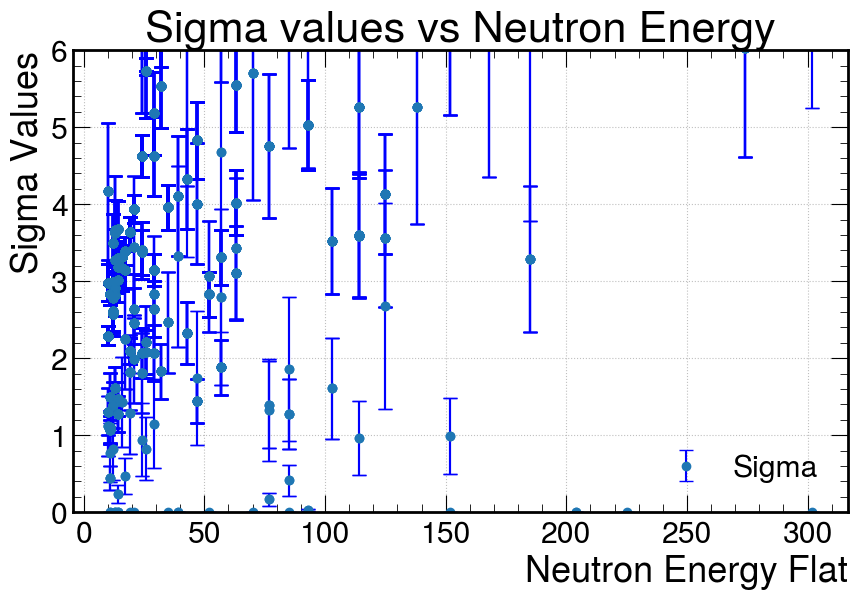

In [10]:
plt.figure(figsize=(10, 6))
plt.errorbar(neutron_energy_flat_filtered, sigma_values_valid, yerr=sigma_errors_valid, fmt='o', label='Sigma', ecolor='blue', capsize=5)
plt.xlabel('Neutron Energy Flat')
plt.ylabel('Sigma Values')

plt.ylim(0,6)

plt.title('Sigma values vs Neutron Energy')
plt.legend()
plt.grid(True)
plt.show()

Number of failed fits: 62
Valid mu values: 9938
Valid sigma values: 9938
Filtered neutron_energy_flat size: 9938


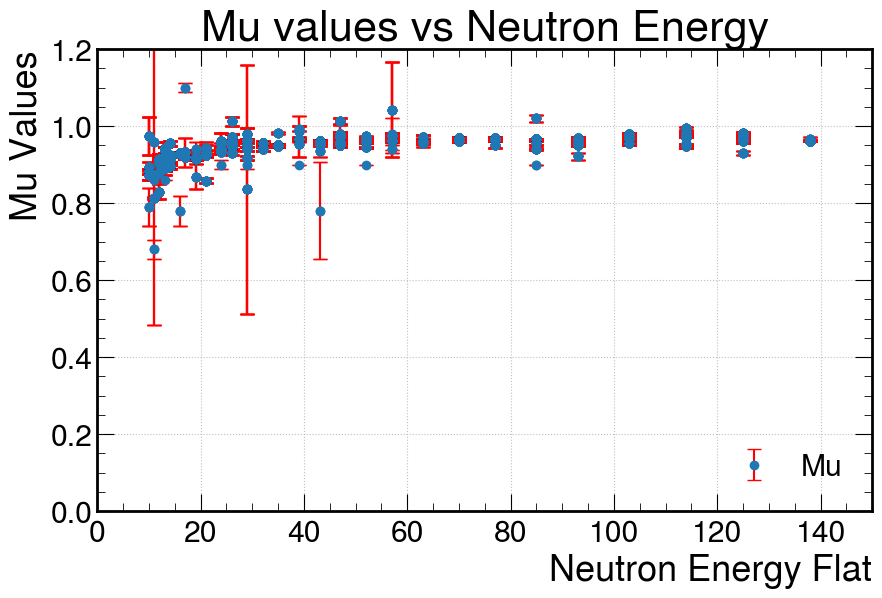

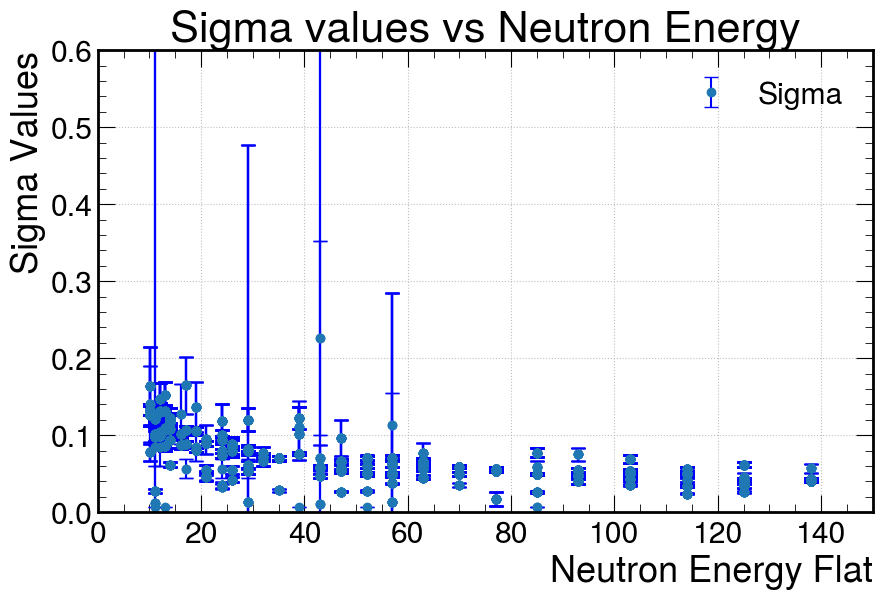

In [11]:
#combine the like plots into one graph first (supposed to slop down like in a log) and then fit it
#sigma function for the calorimeter energy resolution function


import numpy as np
from scipy.optimize import curve_fit
import awkward as ak
import matplotlib.pyplot as plt

# Assuming neutron_energy and reconstructed_event_energy are already defined
# Flatten neutron_energy if not already flattened
neutron_energy_flat = ak.flatten(neutron_energy)

failed_fit_indices = []

def reco(i):
    global failed_fit_indices
    specific_energy = neutron_energy_flat[i]

    # Create a mask for the specific energy
    mask = (neutron_energy_flat == specific_energy)
    masked_reconstructed_energy = reconstructed_event_energy[mask] / neutron_energy_flat[mask]

    # Create a histogram for the masked reconstructed energy
    hist_data, bin_edges = np.histogram(masked_reconstructed_energy, bins=50, range=(0, 2), density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Convert hist_data and bin_centers to NumPy arrays
    hist_data = np.asarray(hist_data)
    bin_centers = np.asarray(bin_centers)

    # Define Gaussian function
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

    # Initial guess for the Gaussian parameters
    initial_guess = [max(hist_data), bin_centers[np.argmax(hist_data)], 1.0]

    try:
        # Perform the Gaussian fit
        bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
        params, covariance = curve_fit(gaussian, bin_centers, hist_data, p0=initial_guess, bounds=bounds, maxfev=5000)
        amplitude, mean, stddev = params
        errors = np.sqrt(np.diag(covariance))  # Standard deviations of parameters
    except RuntimeError as e:
        # If fit fails, record the index
        failed_fit_indices.append(i)
        # Return NaNs for mu, sigma, and errors
        return np.nan, np.nan, np.array([np.nan, np.nan])

    return mean, stddev, errors[1:]  # Return only mean, stddev, and errors for mean and stddev

mu_values = []
sigma_values = []
mu_errors = []
sigma_errors = []

for i in range(len(neutron_energy_flat)):
    mu, sigma, errors = reco(i)
    mu_values.append(mu)
    sigma_values.append(sigma)
    mu_errors.append(errors[0])  # Append error for mean
    sigma_errors.append(errors[1])  # Append error for stddev

# Convert lists to NumPy arrays for easier manipulation
mu_values = np.array(mu_values)
sigma_values = np.array(sigma_values)
mu_errors = np.array(mu_errors)
sigma_errors = np.array(sigma_errors)

# Filter out NaN values (failed fits)
valid_indices = ~np.isnan(mu_values) & ~np.isnan(sigma_values)
mu_values_valid = mu_values[valid_indices]
sigma_values_valid = sigma_values[valid_indices]
mu_errors_valid = mu_errors[valid_indices]
sigma_errors_valid = sigma_errors[valid_indices]

# Filter neutron_energy_flat to exclude entries with failed fits
neutron_energy_flat_filtered = np.delete(neutron_energy_flat, failed_fit_indices)

print(f"Number of failed fits: {len(failed_fit_indices)}")
print("Valid mu values:", len(mu_values_valid))
print("Valid sigma values:", len(sigma_values_valid))
print("Filtered neutron_energy_flat size:", len(neutron_energy_flat_filtered))

# Plotting mu and sigma with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(neutron_energy_flat_filtered, mu_values_valid, yerr=mu_errors_valid, fmt='o', label='Mu', ecolor='red', capsize=5)
plt.xlabel('Neutron Energy Flat')
plt.ylabel('Mu Values')
plt.title('Mu values vs Neutron Energy')
plt.legend()
plt.grid(True)
plt.xlim([0, 150])  # Replace xmin and xmax with your desired range for the x-axis
plt.ylim([0, 1.2])
plt.show()

plt.figure(figsize=(10, 6))
plt.errorbar(neutron_energy_flat_filtered, sigma_values_valid, yerr=sigma_errors_valid, fmt='o', label='Sigma', ecolor='blue', capsize=5)
plt.xlabel('Neutron Energy Flat')
plt.ylabel('Sigma Values')
plt.title('Sigma values vs Neutron Energy')
plt.legend()
plt.grid(True)
plt.xlim([0, 150])  # Replace xmin and xmax with your desired range for the x-axis
plt.ylim([0, 0.6])
plt.show()


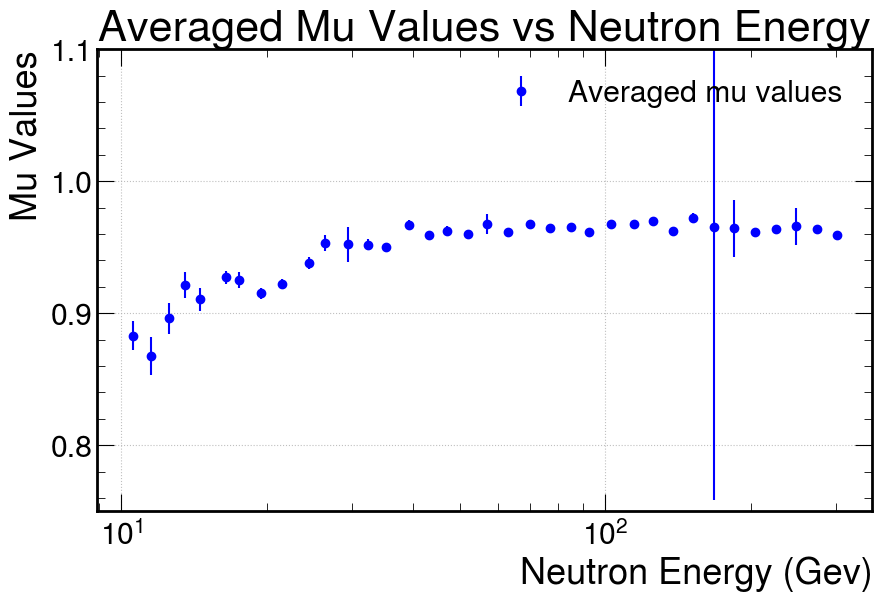

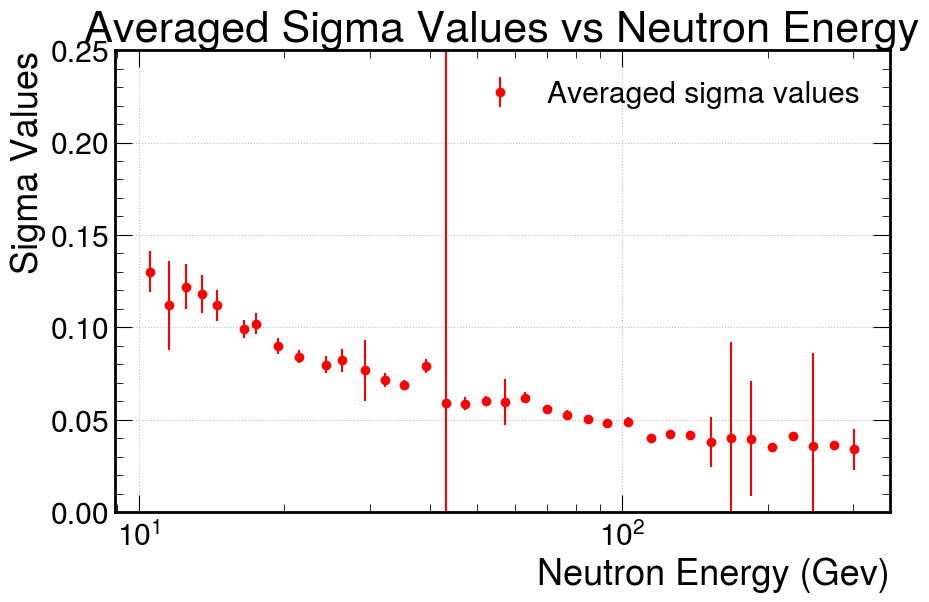

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# Define the bin size
bin_size = 0.99
# Create bins and their centers
min_energy = np.min(neutron_energy_flat_filtered)
max_energy = np.max(neutron_energy_flat_filtered)
bins = np.arange(min_energy, max_energy + bin_size, bin_size)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Initialize arrays to hold binned values
avg_mu_values = np.zeros_like(bin_centers, dtype=float)
avg_sigma_values = np.zeros_like(bin_centers, dtype=float)
avg_mu_errors = np.zeros_like(bin_centers, dtype=float)
avg_sigma_errors = np.zeros_like(bin_centers, dtype=float)
counts = np.zeros_like(bin_centers, dtype=int)
# Calculate averages within each bin
for idx in range(len(bin_centers)):
    mask = (neutron_energy_flat_filtered >= bins[idx]) & (neutron_energy_flat_filtered < bins[idx + 1])
    if np.any(mask):
        avg_mu_values[idx] = np.mean(mu_values_valid[mask])
        avg_sigma_values[idx] = np.mean(sigma_values_valid[mask])
        avg_mu_errors[idx] = np.mean(mu_errors_valid[mask])
        avg_sigma_errors[idx] = np.mean(sigma_errors_valid[mask])
        counts[idx] = np.sum(mask)
# Filter out bins with no counts
valid_bins = counts > 0
bin_centers = bin_centers[valid_bins]
avg_mu_values = avg_mu_values[valid_bins]
avg_sigma_values = avg_sigma_values[valid_bins]
avg_mu_errors = avg_mu_errors[valid_bins]
avg_sigma_errors = avg_sigma_errors[valid_bins]
# Plotting mu values
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, avg_mu_values, yerr=avg_mu_errors, fmt='o', color='b', label='Averaged mu values')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel('Neutron Energy (Gev)')
plt.ylabel('Mu Values')
plt.ylim(0.75, 1.1)
plt.title('Averaged Mu Values vs Neutron Energy')
plt.legend()
plt.grid(True)
plt.show()
# Plotting sigma values
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, avg_sigma_values, yerr=avg_sigma_errors, fmt='o', color='r', label='Averaged sigma values')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel('Neutron Energy (Gev)')
plt.ylabel('Sigma Values')
plt.ylim(0, 0.25)
plt.title('Averaged Sigma Values vs Neutron Energy')
plt.legend()
plt.grid(True)
plt.show()

Number of failed fits: 62
Valid mu values: 9938
Valid sigma values: 9938
Filtered neutron_energy_flat size: 9938
Average Mu: 0.95
Average Sigma: 0.07


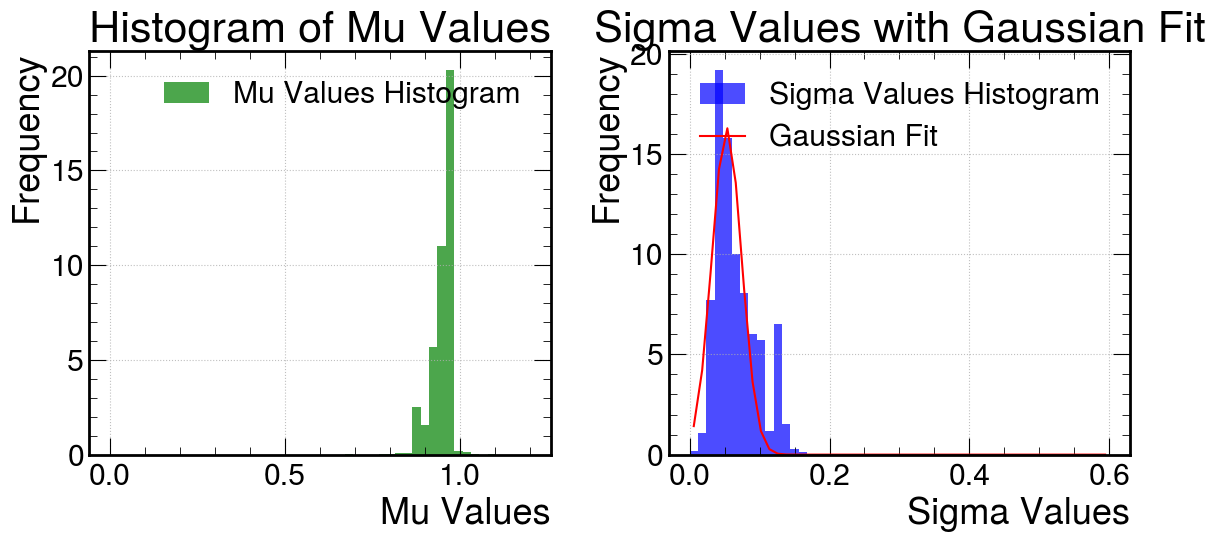

In [13]:
import numpy as np
from scipy.optimize import curve_fit
import awkward as ak
import matplotlib.pyplot as plt

# Assuming neutron_energy and reconstructed_event_energy are already defined
# Flatten neutron_energy if not already flattened
neutron_energy_flat = ak.flatten(neutron_energy)

failed_fit_indices = []

def reco(i):
    global failed_fit_indices
    specific_energy = neutron_energy_flat[i]

    # Create a mask for the specific energy
    mask = (neutron_energy_flat == specific_energy)
    masked_reconstructed_energy = reconstructed_event_energy[mask] / neutron_energy_flat[mask]

    # Create a histogram for the masked reconstructed energy
    hist_data, bin_edges = np.histogram(masked_reconstructed_energy, bins=50, range=(0, 2), density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Convert hist_data and bin_centers to NumPy arrays
    hist_data = np.asarray(hist_data)
    bin_centers = np.asarray(bin_centers)

    # Define Gaussian function
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

    # Initial guess for the Gaussian parameters
    initial_guess = [max(hist_data), bin_centers[np.argmax(hist_data)], 1.0]

    try:
        # Perform the Gaussian fit
        bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
        params, covariance = curve_fit(gaussian, bin_centers, hist_data, p0=initial_guess, bounds=bounds, maxfev=5000)
        amplitude, mean, stddev = params
        errors = np.sqrt(np.diag(covariance))  # Standard deviations of parameters
    except RuntimeError as e:
        # If fit fails, record the index
        failed_fit_indices.append(i)
        # Return NaNs for mu, sigma, and errors
        return np.nan, np.nan, np.array([np.nan, np.nan])

    return mean, stddev, errors[1:]  # Return only mean, stddev, and errors for mean and stddev

mu_values = []
sigma_values = []
mu_errors = []
sigma_errors = []

for i in range(len(neutron_energy_flat)):
    mu, sigma, errors = reco(i)
    mu_values.append(mu)
    sigma_values.append(sigma)
    mu_errors.append(errors[0])  # Append error for mean
    sigma_errors.append(errors[1])  # Append error for stddev

# Convert lists to NumPy arrays for easier manipulation
mu_values = np.array(mu_values)
sigma_values = np.array(sigma_values)
mu_errors = np.array(mu_errors)
sigma_errors = np.array(sigma_errors)

# Filter out NaN values (failed fits)
valid_indices = ~np.isnan(mu_values) & ~np.isnan(sigma_values)
mu_values_valid = mu_values[valid_indices]
sigma_values_valid = sigma_values[valid_indices]
mu_errors_valid = mu_errors[valid_indices]
sigma_errors_valid = sigma_errors[valid_indices]

# Filter neutron_energy_flat to exclude entries with failed fits
neutron_energy_flat_filtered = np.delete(neutron_energy_flat, failed_fit_indices)

print(f"Number of failed fits: {len(failed_fit_indices)}")
print("Valid mu values:", len(mu_values_valid))
print("Valid sigma values:", len(sigma_values_valid))
print("Filtered neutron_energy_flat size:", len(neutron_energy_flat_filtered))

# Calculate average mu and sigma values
avg_mu = np.mean(mu_values_valid)
avg_sigma = np.mean(sigma_values_valid)

print(f"Average Mu: {avg_mu:.2f}")
print(f"Average Sigma: {avg_sigma:.2f}")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Mu histogram
ax1.hist(mu_values_valid, bins=50, range=(0, 1.2), density=True, color='g', alpha=0.7, label='Mu Values Histogram')
ax1.set_xlabel('Mu Values')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Mu Values')
ax1.grid(True)
ax1.legend()

# Plot Sigma histogram and Gaussian fit
ax2.hist(sigma_values_valid, bins=50, range=(0, 0.6), density=True, color='b', alpha=0.7, label='Sigma Values Histogram')

# Fit the histogram data for Sigma values
def gaussian(x, A, mean, stddev):
    return A * np.exp(-(x - mean) ** 2 / (2 * stddev ** 2))

hist_data, bin_edges = np.histogram(sigma_values_valid, bins=50, range=(0, 0.6), density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
popt, pcov = curve_fit(gaussian, bin_centers, hist_data, p0=[1.0, np.mean(sigma_values_valid), np.std(sigma_values_valid)])
ax2.plot(bin_centers, gaussian(bin_centers, *popt), 'r-', label='Gaussian Fit')

ax2.set_xlabel('Sigma Values')
ax2.set_ylabel('Frequency')
ax2.set_title('Sigma Values with Gaussian Fit')
ax2.legend()
ax2.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


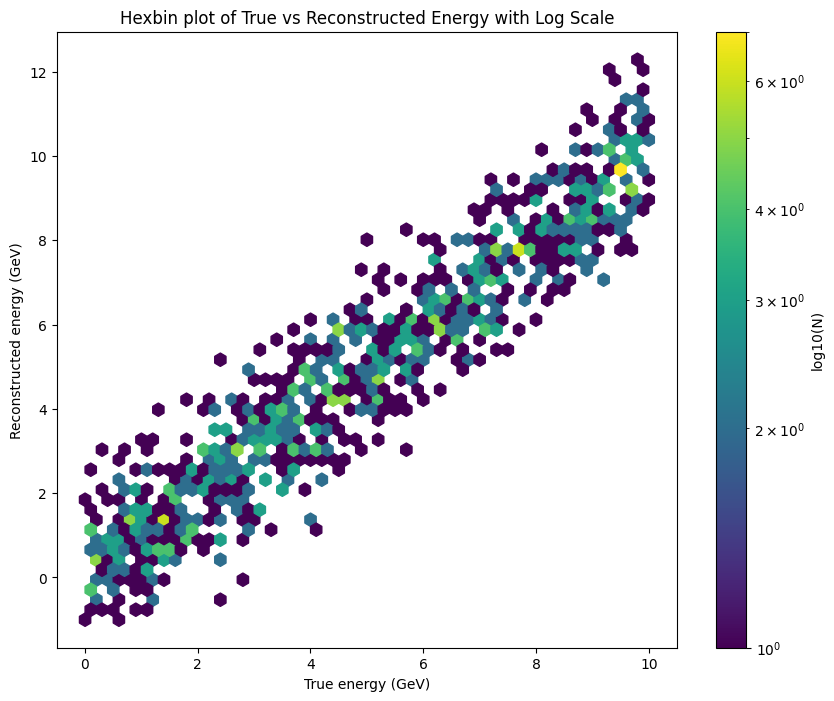

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Sample data generation for demonstration
np.random.seed(0)
neutron_energy = np.random.uniform(0, 10, 1000)  # True energy in GeV
reconstructed_event_energy = neutron_energy + np.random.normal(0, 1, 1000)  # Reconstructed energy with some noise

# Creating a scatter plot with a density-based color mapping
fig, ax = plt.subplots(figsize=(10, 8))
hb = ax.hexbin(neutron_energy, reconstructed_event_energy, gridsize=50, cmap='viridis', bins='log')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

plt.xlabel("True energy (GeV)")
plt.ylabel("Reconstructed energy (GeV)")
plt.title("Hexbin plot of True vs Reconstructed Energy with Log Scale")
plt.show()


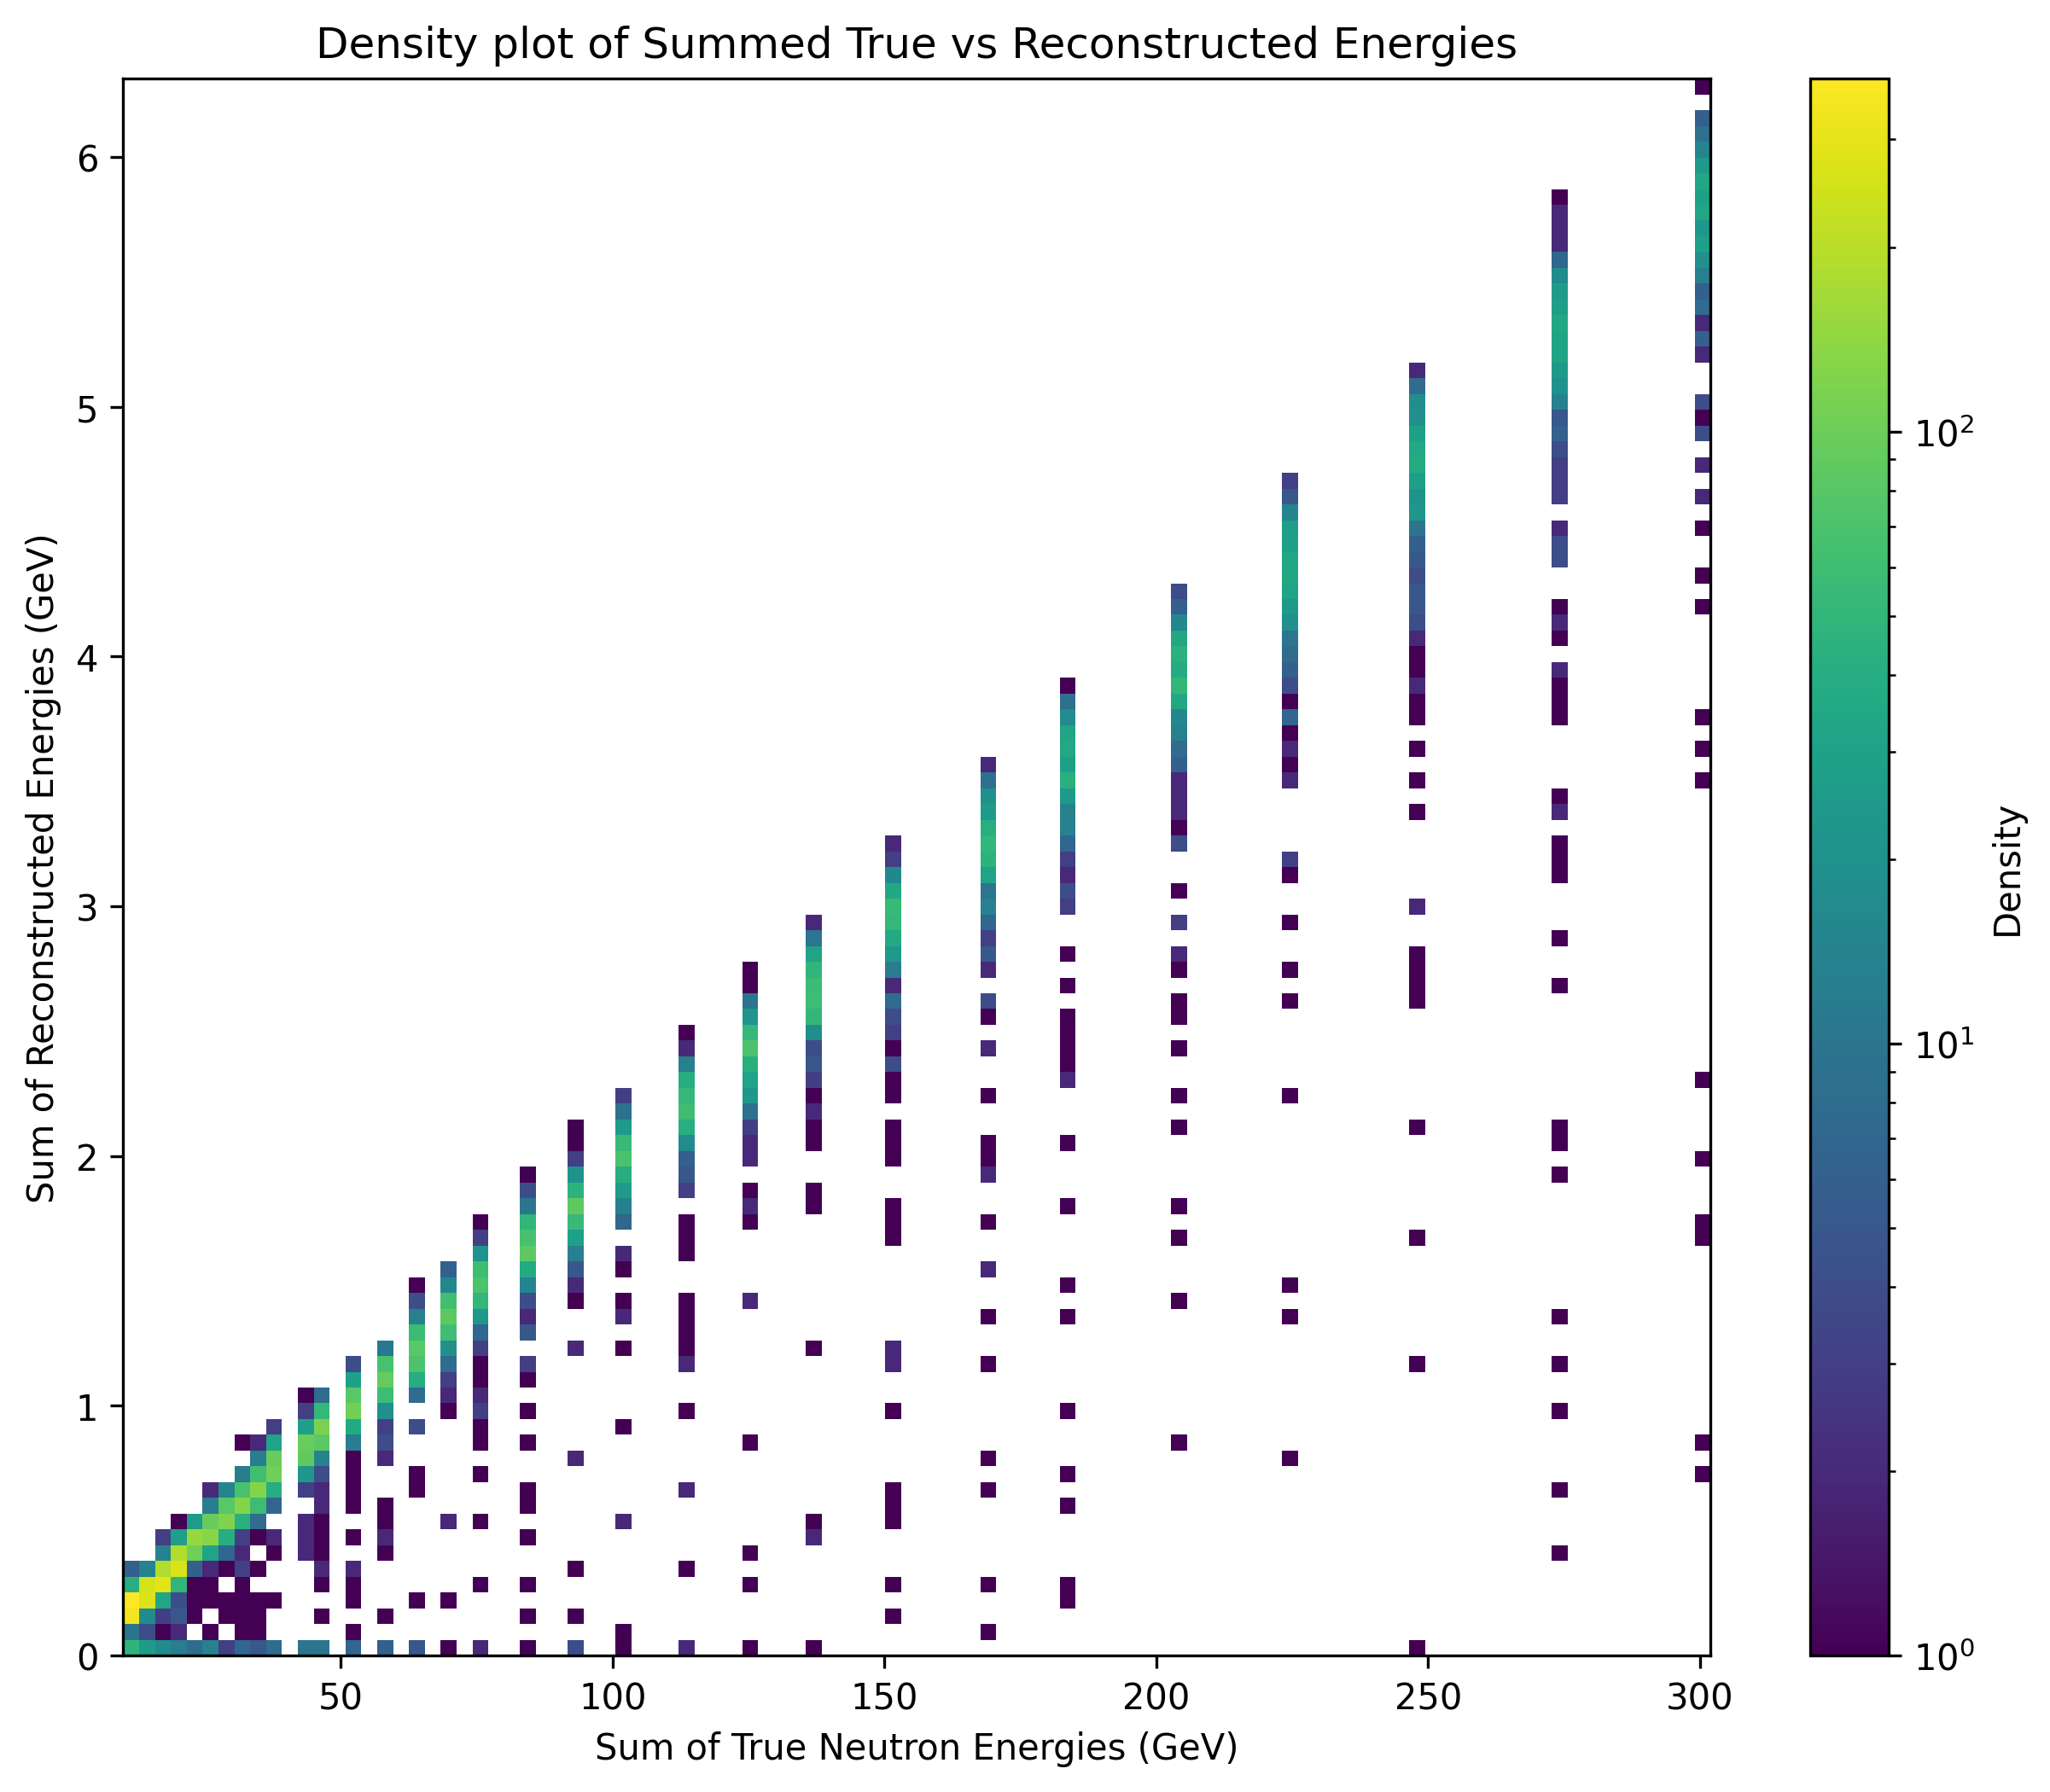

In [5]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Data directory and file name
data_directory = "/media/miguel/Elements/zdc_data/zdc_neutron_log10discrete_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/"
file_name = "reco_neutron_discrete_10GeV-300GeV_theta_0.0deg-0.3deg_1325547_0.edm4hep.root"

# Open the ROOT file and access the events tree
file_path = data_directory + file_name
with uproot.open(file_path + ":events") as events:
    # Load arrays
    zdc_MC = events.arrays(["MCParticles.generatorStatus", "MCParticles.PDG",
                            'MCParticles.momentum.x', 'MCParticles.momentum.y', 'MCParticles.momentum.z'], library="ak")
    zdc_reco = events.arrays(["ZDCHcalHitsReco.energy"], library="ak")

    # Apply neutron filter
    neutron_mask = (zdc_MC["MCParticles.generatorStatus"] == 1) & (zdc_MC["MCParticles.PDG"] == 2112)
    neutron_momenta = zdc_MC["MCParticles.momentum.x"]**2 + zdc_MC["MCParticles.momentum.y"]**2 + zdc_MC["MCParticles.momentum.z"]**2
    neutron_energy = np.sqrt(neutron_momenta[neutron_mask])

    # Aggregate energies
    if ak.num(neutron_energy, axis=0) > 1:
        neutron_total_energy = ak.sum(neutron_energy, axis=1)  # Sum neutron energies per event
    else:
        neutron_total_energy = neutron_energy  # Use as is if only one dimension

    if ak.num(zdc_reco["ZDCHcalHitsReco.energy"], axis=0) > 1:
        reconstructed_total_energy = ak.sum(zdc_reco["ZDCHcalHitsReco.energy"], axis=1)  # Sum reconstructed energies per event
    else:
        reconstructed_total_energy = zdc_reco["ZDCHcalHitsReco.energy"]  # Use as is if only one dimension

    # Check if lengths are the same and adjust if necessary
    min_length = min(len(neutron_total_energy), len(reconstructed_total_energy))
    neutron_total_energy = neutron_total_energy[:min_length]
    reconstructed_total_energy = reconstructed_total_energy[:min_length]

    # Plotting
    plt.figure(figsize=(10, 8), dpi=300)  # Increase DPI for higher resolution
    plt.hist2d(ak.to_numpy(neutron_total_energy), ak.to_numpy(reconstructed_total_energy), bins=100, norm=mcolors.LogNorm(), cmap='viridis')  # Increase bins for smoother transitions
    plt.colorbar(label='Density')
    plt.xlabel("Sum of True Neutron Energies (GeV)")
    plt.ylabel("Sum of Reconstructed Energies (GeV)")
    plt.title("Density plot of Summed True vs Reconstructed Energies")
    plt.show()


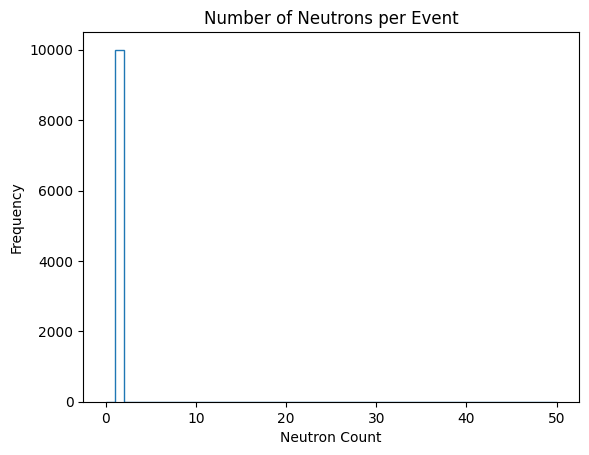

Number of events: 10000


In [6]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# Define the data directory and file name
data_directory = "/media/miguel/Elements/zdc_data/zdc_neutron_log10discrete_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/"
file_name = "reco_neutron_discrete_10GeV-300GeV_theta_0.0deg-0.3deg_1325547_0.edm4hep.root"

# Open the ROOT file
with uproot.open(f"{data_directory + file_name}:events") as events:
    # Obtain arrays for MCParticles branch
    zdc_MC = events.arrays(["MCParticles.generatorStatus", "MCParticles.PDG"])
    
    # Neutron PDG ID
    neutron_pdg_id = 2112

    # Extract the necessary branches
    generator_status = zdc_MC["MCParticles.generatorStatus"]
    pdg_ids = zdc_MC["MCParticles.PDG"]

    # Apply the neutron mask
    neutron_mask = (generator_status == 1) & (pdg_ids == neutron_pdg_id)
    neutron_counts = ak.sum(neutron_mask, axis=1)

    # Plot the histogram
    plt.hist(neutron_counts, bins=50, range=(0, 50), histtype='step')
    plt.title('Number of Neutrons per Event')
    plt.xlabel('Neutron Count')
    plt.ylabel('Frequency')
    plt.savefig('neutron_count_matplotlib.png')
    plt.show()

    # Print the number of events
    print("Number of events:", events.num_entries)


In [ ]:
# Opening a data file. You can choose any data file from the below data_directory.
data_directory = "/media/miguel/Elements/zdc_data/zdc_neutron_log10discrete_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/"
file_name = "reco_neutron_discrete_10GeV-300GeV_theta_0.0deg-0.3deg_1325547_0.edm4hep.root"
with ur.open(f"{data_directory + file_name}:events") as events:
    # Obtaining arrays for MCparticles branch
    zdc_MC = events.arrays(["MCParticles.generatorStatus", "MCParticles.PDG",'MCParticles.mass',
                            'MCParticles.momentum.x', 'MCParticles.momentum.y', 'MCParticles.momentum.z'])
    # Obtaining arrays for ZDCHcalHitsReco branch
    zdc_reco = events.arrays(["ZDCHcalHitsReco.energy", "ZDCHcalHitsReco.time",
                             "ZDCHcalHitsReco.position.x", "ZDCHcalHitsReco.position.y", "ZDCHcalHitsReco.position.z"])
    print("Number of events:", events.num_entries)